# Link prediction
In this notebook we do link prediction starting from the embeddings
previously obtained from for example Skipgram, CBOW, GloVe

Graphs used in the NB are available here:
http://doi.org/10.5281/zenodo.4011267

In [24]:
import silence_tensorflow.auto # Import needed to avoid TensorFlow warnings and general useless infos.

In [25]:
graph_data_dir = "graph"

In [26]:
# get the graphs

import urllib
import os
os.makedirs(graph_data_dir, exist_ok=True)
if not os.path.exists(graph_data_dir + "/kg-covid-19-skipgram-aug-2020.tar.gz"):
    with urllib.request.urlopen("https://zenodo.org/record/4011267/files/kg-covid-19-skipgram-aug-2020.tar.gz") as response, \
        open(graph_data_dir + "/kg-covid-19-skipgram-aug-2020.tar.gz", 'wb') as out_file:
            data = response.read()  # a `bytes` object
            out_file.write(data)

os.system("tar -xvzf " + graph_data_dir + "/kg-covid-19-skipgram-aug-2020.tar.gz -C " + graph_data_dir)

0

## Retrieve the embeddings

## Edge embeddings
We will compute the edge embeddings using all the 5 available methods:

- Hadamart: an element-wise product
- Mean
- Norm L1
- Norm L2
- Concatenation

## Defining a simple Feed Forward Neural Network

In [27]:
import os

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Dropout
from tensorflow.keras.metrics import AUC, Recall, Precision

def build_link_prediction_model(input_shape:int):
    model = Sequential([
        Input(input_shape),
        Dense(256, activation="relu"),
        Dense(64, activation="relu"),
        Dropout(0.5),
        Dense(16, activation="relu"),
        Dense(1, activation="sigmoid")
    ])
    model.compile(
        loss="binary_crossentropy",
        optimizer="nadam",
        metrics=[
            AUC(curve="PR", name="auprc"),
            AUC(curve="ROC", name="auroc"),
            Recall(),
            Precision(),
            "accuracy"
        ]
    )
    return model

## Loading the graph

In [29]:
from ensmallen_graph import EnsmallenGraph

graph = EnsmallenGraph.from_csv(
    edge_path= graph_data_dir + "/merged-kg_edges.tsv",
    sources_column="subject",
    destinations_column="object",
    directed=False,
    default_edge_type="biolink:association",
    node_path= graph_data_dir + "/merged-kg_nodes.tsv",
    nodes_column="id",
    node_types_column="category",
    default_node_type="biolink:NamedThing",
    ignore_duplicated_edges=True,
    ignore_duplicated_nodes=True,
    force_conversion_to_undirected=True
)

In [30]:
graph.report()

{'unique_node_types_number': '36',
 'degrees_median': '6',
 'degrees_mean': '82.21604837957722',
 'traps_rate': '0.021906677500566116',
 'degrees_max': '90378',
 'edges_number': '30861027',
 'singleton_nodes': '8223',
 'is_directed': 'false',
 'unique_edge_types_number': '0',
 'selfloops_rate': '0.000015391581103247148',
 'connected_components_number': '8976',
 'density': '0.00021902960686152735',
 'degrees_min': '0',
 'strongly_connected_components_number': '8976',
 'degrees_mode': '1',
 'bidirectional_rate': '1',
 'nodes_number': '375365'}

## Defining holdouts and tasks data generator
We are going to create the same edge embeddings as in the training of the embeddings.

In [31]:
seed = 42
train_percentage = 0.8

pos_training, pos_validation = graph.connected_holdout(seed, train_percentage)

In [32]:
# hack to use kg-covid-19 for negative edge sampling until we get high mem issue sorted
import os
if not os.path.exists("kg-covid-19"):
    cmd = "git clone https://github.com/Knowledge-Graph-Hub/kg-covid-19.git"
    returned_value = os.system(cmd)

if not os.path.exists("kg-covid-19/data/edges/neg_test_edges.tsv") \
    or not os.path.exists("kg-covid-19/data/edges/neg_train_edges.tsv"):
        cmd = f"cd kg-covid-19;python run.py edges -n ../{graph_data_dir}/merged-kg_nodes-min.tsv -e ../{graph_data_dir}/merged-kg_edges-min.tsv; cd .."
        returned_value = os.system(cmd)

In [33]:
# neg_training, neg_validation = graph.sample_negatives(
#    seed=seed,
#    negatives_number=graph.get_edges_number(),
#    allow_selfloops=False
#).random_holdout(seed=seed, train_percentage=train_percentage)

In [34]:
from ensmallen_graph import EnsmallenGraph

neg_validation = EnsmallenGraph.from_csv(
    edge_path="kg-covid-19/data/edges/neg_test_edges.tsv",
    sources_column="subject",
    destinations_column="object",
    directed=False,
    edge_types_column="edge_label",
    default_node_type="biolink:NamedThing",
    ignore_duplicated_edges=True,
    ignore_duplicated_nodes=True,
    force_conversion_to_undirected=True
)

neg_training = EnsmallenGraph.from_csv(
    edge_path="kg-covid-19/data/edges/neg_train_edges.tsv",
    sources_column="subject",
    destinations_column="object",
    directed=False,
    edge_types_column="edge_label",
    default_node_type="biolink:NamedThing",
    ignore_duplicated_edges=True,
    ignore_duplicated_nodes=True,
    force_conversion_to_undirected=True
)

In [35]:
# https://zenodo.org/record/4019808/files/SkipGram_80_20_training_test_epoch_500_delta_0.0001_embedding.npy?download=1
if not os.path.exists("SkipGram_embedding.npy"):
    with urllib.request.urlopen("https://zenodo.org/record/4019808/files/SkipGram_80_20_training_test_epoch_500_delta_0.0001_embedding.npy") as response, \
        open("SkipGram_embedding.npy", 'wb') as out_file:
            data = response.read()  # a `bytes` object
            out_file.write(data)

In [36]:
from tqdm.auto import tqdm
from glob import glob
from embiggen import GraphTransformer, EdgeTransformer
import numpy as np
import pandas as pd

def task_generator(
    pos_training:EnsmallenGraph,
    pos_validation:EnsmallenGraph,
    neg_training:EnsmallenGraph,
    neg_validation:EnsmallenGraph,
    train_percentage:float=train_percentage,
    seed:int=seed
):
    """Create new generator of tasks.

    Parameters
    ----------------------------------
    pos_training:EnsmallenGraph,
        The positive edges of the training graph.
    pos_validation:EnsmallenGraph,
        The positive edges of the validation graph.
    neg_training:EnsmallenGraph,
        The negative edges of the training graph.
    neg_validation:EnsmallenGraph,
        The negative edges of the validation graph.
    train_percentage:float=0.8,
    seed:int=42

    """
    for path in tqdm(glob("*embedding.npy"), desc="Embedding"):
        model_name = path.split("_")[0]
        embedding = np.load(path)
        for method in tqdm(EdgeTransformer.methods, desc="Methods", leave=False):
            transformer = GraphTransformer(method)
            transformer.fit(embedding)
            train_edges = np.vstack([
                transformer.transform(graph)
                for graph in (pos_training, neg_training)
            ])
            valid_edges = np.vstack([
                transformer.transform(graph)
                for graph in (pos_validation, neg_validation)
            ])
            train_labels = np.concatenate([
                np.ones(pos_training.get_edges_number()),
                np.zeros(neg_training.get_edges_number())
            ])
            valid_labels = np.concatenate([
                np.ones(pos_validation.get_edges_number()),
                np.zeros(neg_validation.get_edges_number())
            ])
            train_indices = np.arange(0, train_labels.size)
            valid_indices = np.arange(0, valid_labels.size)
            np.random.shuffle(train_indices)
            np.random.shuffle(valid_indices)
            train_edges = train_edges[train_indices]
            train_labels = train_labels[train_indices]
            valid_edges = valid_edges[valid_indices]
            valid_labels = valid_labels[valid_indices]
            yield model_name, method, (train_edges, train_labels), (valid_edges, valid_labels)

## Training the models

In [37]:
from tensorflow.distribute import MirroredStrategy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

histories = {}
strategy = MirroredStrategy()
os.makedirs("classical_link_prediction", exist_ok=True)

for embedding_model, method, train, valid in task_generator(pos_training, pos_validation, neg_training, neg_validation):
    history_path = f"classical_link_prediction/{embedding_model}_{method}.csv"
    if os.path.exists(history_path):
        histories[(embedding_model, method)] = pd.read_csv(history_path)
        continue
    with strategy.scope():
        model = build_link_prediction_model(train[0].shape[1:])
        
        history = pd.DataFrame(model.fit(
            *train,
            batch_size=2**12,
            validation_data=valid,
            epochs=1000,
            callbacks=[
                EarlyStopping("val_loss", patience=20, min_delta=0.0001),
                ReduceLROnPlateau()
            ]
        ).history)

        history.to_csv(history_path, index=False)
        histories[(embedding_model, method)] = history
        
        model.save(f"{embedding_model}_{method}_finalized_model.h5")


Epoch 1/1000
14383/14383 [==============================] - 169s 12ms/step - loss: 0.1640 - auprc: 0.9721 - auroc: 0.9783 - recall_3: 0.9254 - precision_3: 0.9530 - accuracy: 0.9496 - val_loss: 0.1921 - val_auprc: 0.9807 - val_auroc: 0.9867 - val_recall_3: 0.9603 - val_precision_3: 0.9465 - val_accuracy: 0.9606
Epoch 2/1000
14383/14383 [==============================] - 155s 11ms/step - loss: 0.1354 - auprc: 0.9808 - auroc: 0.9845 - recall_3: 0.9382 - precision_3: 0.9598 - accuracy: 0.9576 - val_loss: 0.1709 - val_auprc: 0.9826 - val_auroc: 0.9883 - val_recall_3: 0.9673 - val_precision_3: 0.9411 - val_accuracy: 0.9609
Epoch 3/1000
14383/14383 [==============================] - 156s 11ms/step - loss: 0.1314 - auprc: 0.9818 - auroc: 0.9856 - recall_3: 0.9406 - precision_3: 0.9599 - accuracy: 0.9587 - val_loss: 0.1674 - val_auprc: 0.9828 - val_auroc: 0.9884 - val_recall_3: 0.9719 - val_precision_3: 0.9301 - val_accuracy: 0.9576
Epoch 4/1000
14383/14383 [==============================] - 1

14383/14383 [==============================] - 156s 11ms/step - loss: 0.1208 - auprc: 0.9846 - auroc: 0.9882 - recall_3: 0.9472 - precision_3: 0.9603 - accuracy: 0.9615 - val_loss: 0.1704 - val_auprc: 0.9853 - val_auroc: 0.9899 - val_recall_3: 0.9784 - val_precision_3: 0.9197 - val_accuracy: 0.9552
Epoch 28/1000
14383/14383 [==============================] - 155s 11ms/step - loss: 0.1208 - auprc: 0.9846 - auroc: 0.9882 - recall_3: 0.9472 - precision_3: 0.9603 - accuracy: 0.9615 - val_loss: 0.1679 - val_auprc: 0.9853 - val_auroc: 0.9899 - val_recall_3: 0.9785 - val_precision_3: 0.9193 - val_accuracy: 0.9550
Epoch 29/1000
14383/14383 [==============================] - 156s 11ms/step - loss: 0.1207 - auprc: 0.9846 - auroc: 0.9882 - recall_3: 0.9472 - precision_3: 0.9603 - accuracy: 0.9615 - val_loss: 0.1719 - val_auprc: 0.9848 - val_auroc: 0.9897 - val_recall_3: 0.9784 - val_precision_3: 0.9203 - val_accuracy: 0.9554
Epoch 1/1000
14383/14383 [==============================] - 170s 12ms/st

14383/14383 [==============================] - 157s 11ms/step - loss: 0.1000 - auprc: 0.9887 - auroc: 0.9924 - recall_4: 0.9575 - precision_4: 0.9629 - accuracy: 0.9667 - val_loss: 0.1162 - val_auprc: 0.9893 - val_auroc: 0.9931 - val_recall_4: 0.9628 - val_precision_4: 0.9651 - val_accuracy: 0.9698
Epoch 25/1000
14383/14383 [==============================] - 157s 11ms/step - loss: 0.1000 - auprc: 0.9887 - auroc: 0.9924 - recall_4: 0.9575 - precision_4: 0.9630 - accuracy: 0.9667 - val_loss: 0.1166 - val_auprc: 0.9892 - val_auroc: 0.9931 - val_recall_4: 0.9622 - val_precision_4: 0.9655 - val_accuracy: 0.9698
Epoch 26/1000
14383/14383 [==============================] - 154s 11ms/step - loss: 0.1000 - auprc: 0.9887 - auroc: 0.9924 - recall_4: 0.9575 - precision_4: 0.9630 - accuracy: 0.9668 - val_loss: 0.1182 - val_auprc: 0.9892 - val_auroc: 0.9931 - val_recall_4: 0.9615 - val_precision_4: 0.9660 - val_accuracy: 0.9697
Epoch 27/1000
14383/14383 [==============================] - 155s 11ms/s

14383/14383 [==============================] - 150s 10ms/step - loss: 0.1346 - auprc: 0.9818 - auroc: 0.9863 - recall_5: 0.9398 - precision_5: 0.9530 - accuracy: 0.9554 - val_loss: 0.1426 - val_auprc: 0.9824 - val_auroc: 0.9877 - val_recall_5: 0.9405 - val_precision_5: 0.9598 - val_accuracy: 0.9585
Epoch 21/1000
14383/14383 [==============================] - 154s 11ms/step - loss: 0.1346 - auprc: 0.9818 - auroc: 0.9863 - recall_5: 0.9399 - precision_5: 0.9531 - accuracy: 0.9554 - val_loss: 0.1415 - val_auprc: 0.9825 - val_auroc: 0.9877 - val_recall_5: 0.9409 - val_precision_5: 0.9594 - val_accuracy: 0.9586
Epoch 22/1000
14383/14383 [==============================] - 152s 11ms/step - loss: 0.1345 - auprc: 0.9818 - auroc: 0.9863 - recall_5: 0.9399 - precision_5: 0.9531 - accuracy: 0.9554 - val_loss: 0.1412 - val_auprc: 0.9827 - val_auroc: 0.9878 - val_recall_5: 0.9418 - val_precision_5: 0.9590 - val_accuracy: 0.9587
Epoch 23/1000
14383/14383 [==============================] - 152s 11ms/s

14383/14383 [==============================] - 147s 10ms/step - loss: 0.1353 - auprc: 0.9816 - auroc: 0.9861 - recall_6: 0.9385 - precision_6: 0.9538 - accuracy: 0.9552 - val_loss: 0.1352 - val_auprc: 0.9831 - val_auroc: 0.9880 - val_recall_6: 0.9549 - val_precision_6: 0.9481 - val_accuracy: 0.9592
Epoch 19/1000
14383/14383 [==============================] - 148s 10ms/step - loss: 0.1341 - auprc: 0.9819 - auroc: 0.9864 - recall_6: 0.9391 - precision_6: 0.9543 - accuracy: 0.9556 - val_loss: 0.1351 - val_auprc: 0.9831 - val_auroc: 0.9881 - val_recall_6: 0.9544 - val_precision_6: 0.9493 - val_accuracy: 0.9595
Epoch 20/1000
14383/14383 [==============================] - 147s 10ms/step - loss: 0.1338 - auprc: 0.9820 - auroc: 0.9864 - recall_6: 0.9393 - precision_6: 0.9543 - accuracy: 0.9557 - val_loss: 0.1355 - val_auprc: 0.9831 - val_auroc: 0.9881 - val_recall_6: 0.9551 - val_precision_6: 0.9486 - val_accuracy: 0.9595
Epoch 21/1000
14383/14383 [==============================] - 149s 10ms/s

14383/14383 [==============================] - 150s 10ms/step - loss: 0.1334 - auprc: 0.9821 - auroc: 0.9865 - recall_6: 0.9398 - precision_6: 0.9543 - accuracy: 0.9559 - val_loss: 0.1344 - val_auprc: 0.9830 - val_auroc: 0.9880 - val_recall_6: 0.9545 - val_precision_6: 0.9494 - val_accuracy: 0.9596
Epoch 45/1000
14383/14383 [==============================] - 149s 10ms/step - loss: 0.1333 - auprc: 0.9821 - auroc: 0.9865 - recall_6: 0.9399 - precision_6: 0.9544 - accuracy: 0.9560 - val_loss: 0.1344 - val_auprc: 0.9830 - val_auroc: 0.9881 - val_recall_6: 0.9550 - val_precision_6: 0.9489 - val_accuracy: 0.9596
Epoch 46/1000
14383/14383 [==============================] - 151s 10ms/step - loss: 0.1332 - auprc: 0.9821 - auroc: 0.9865 - recall_6: 0.9399 - precision_6: 0.9544 - accuracy: 0.9560 - val_loss: 0.1344 - val_auprc: 0.9830 - val_auroc: 0.9881 - val_recall_6: 0.9549 - val_precision_6: 0.9490 - val_accuracy: 0.9596
Epoch 47/1000
14383/14383 [==============================] - 149s 10ms/s

## Plotting all the computer histories

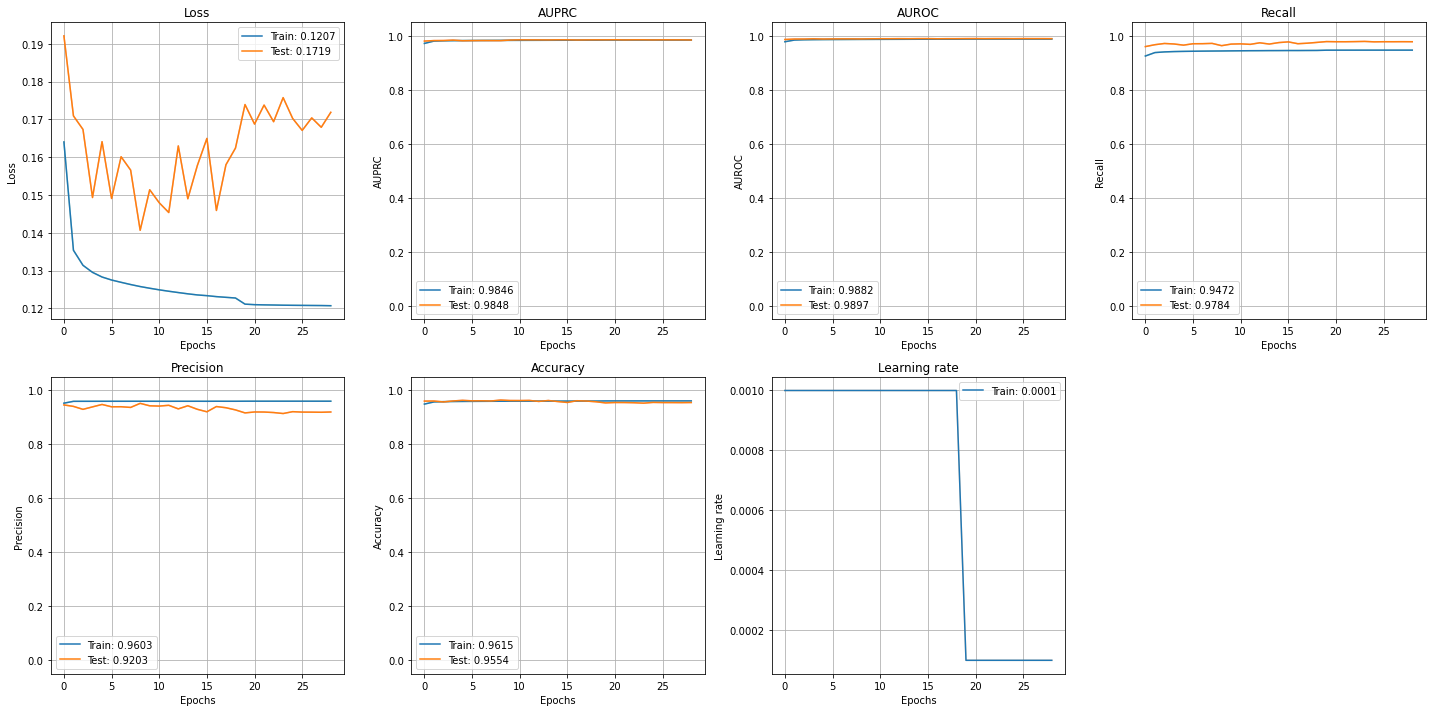

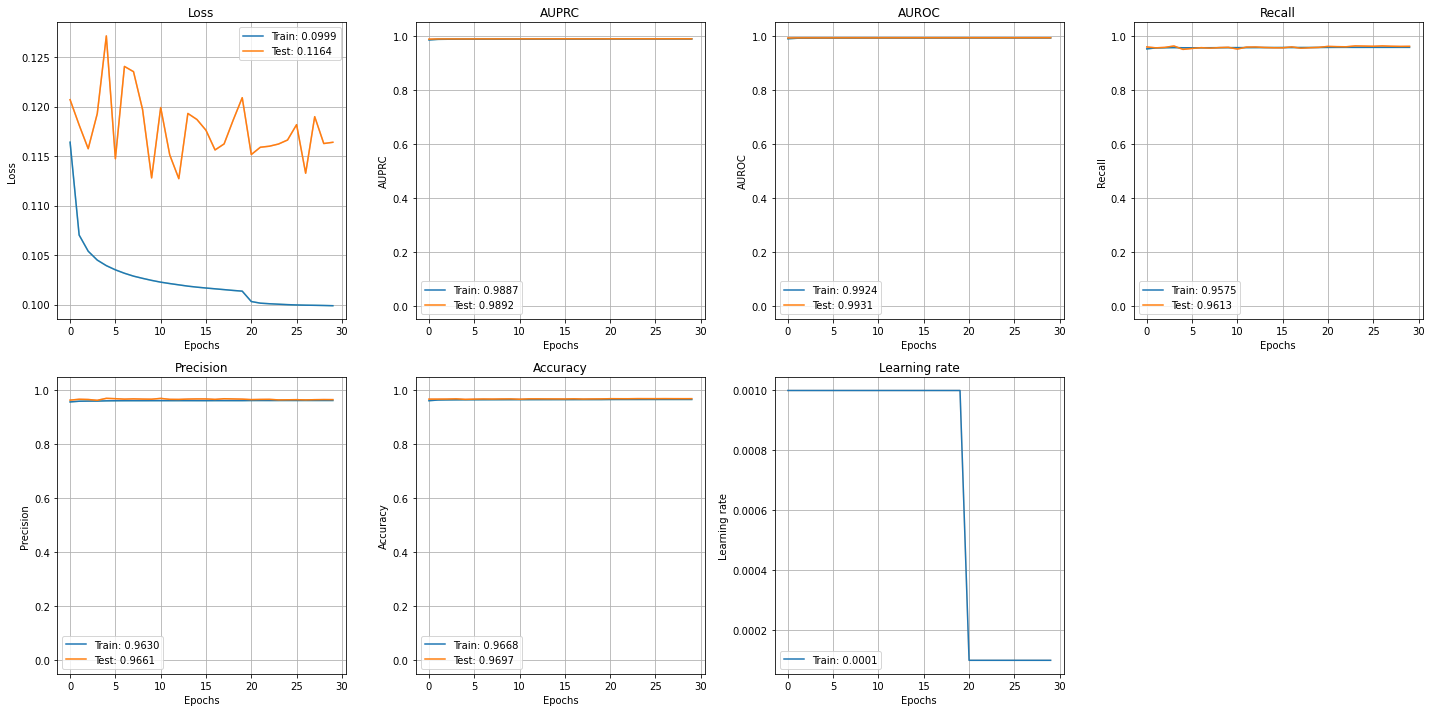

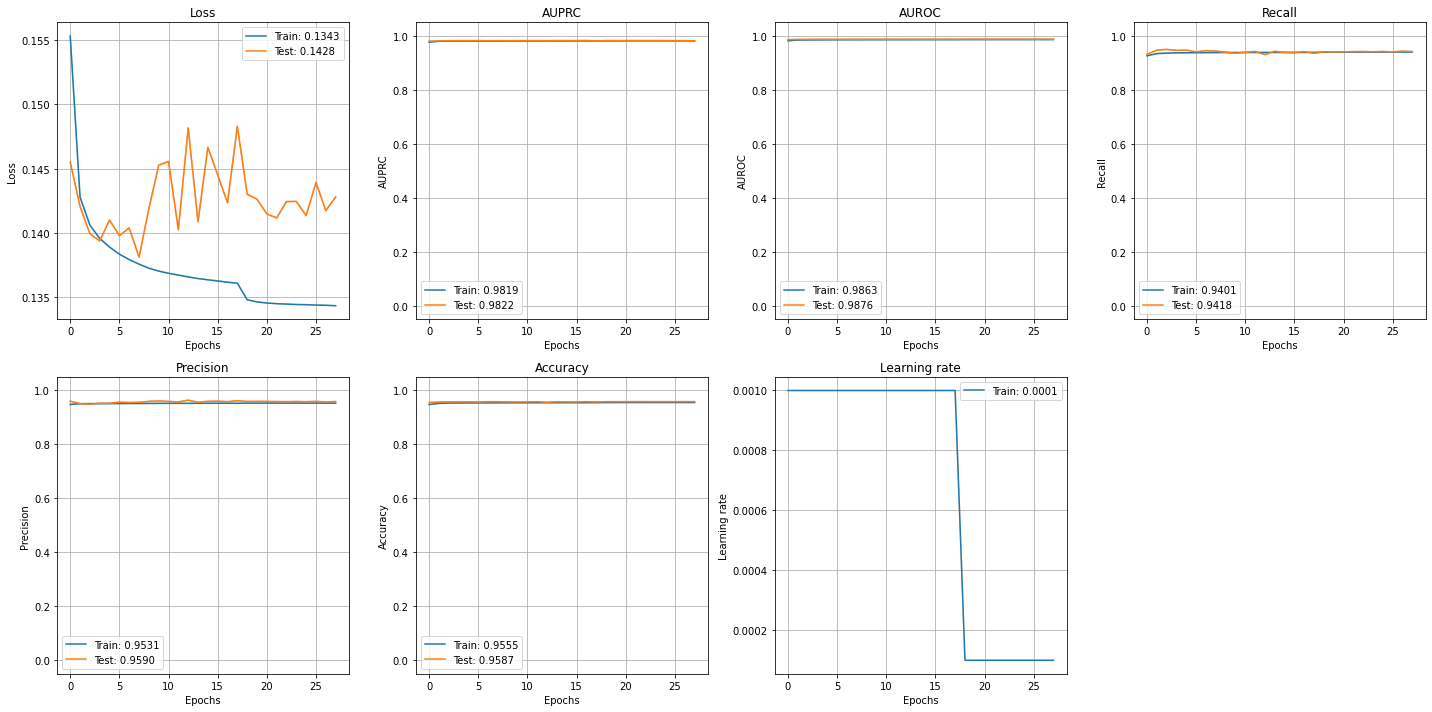

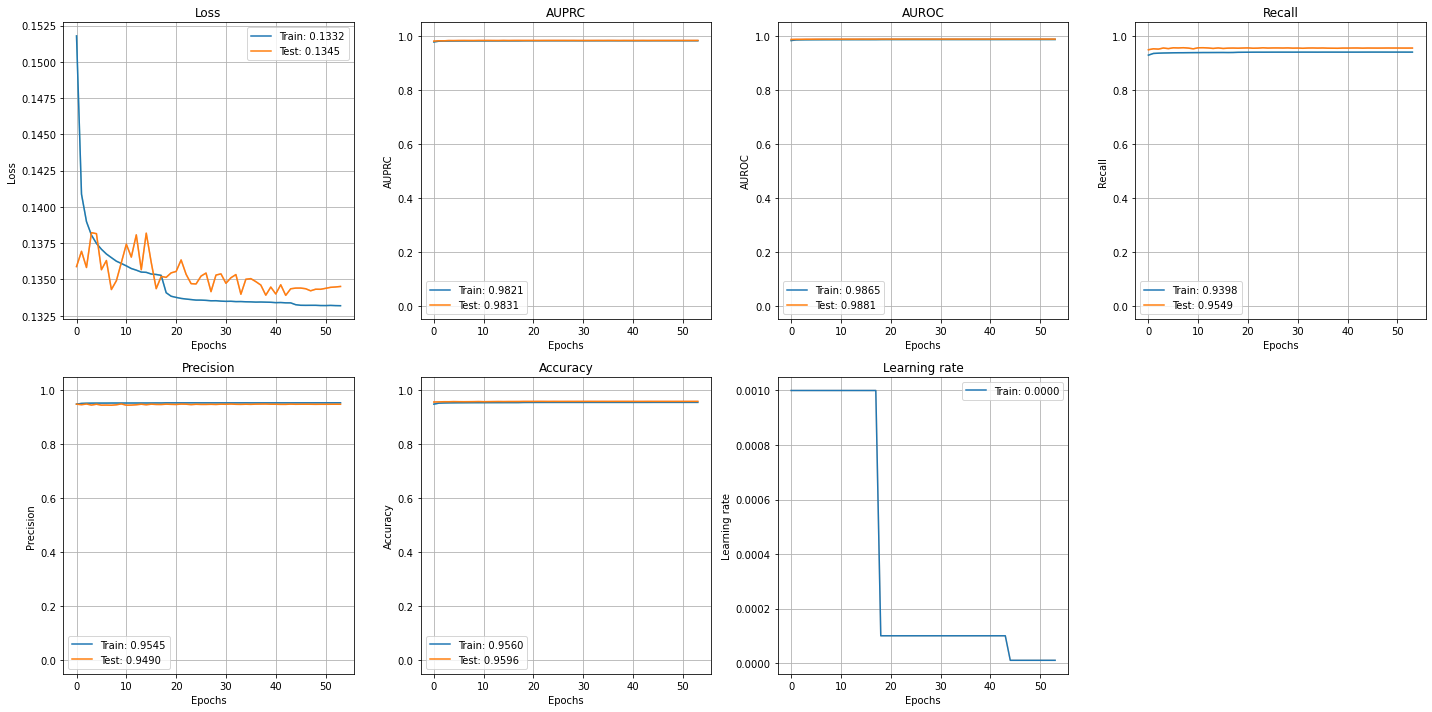

In [38]:
from plot_keras_history import plot_history

for history in histories.values():
    plot_history(history)

## Displaying results of various embedding methods

First we covert the histories into an homogeneous report:

In [39]:
from sanitize_ml_labels import sanitize_ml_labels

report = []
for (model, method), history in histories.items():
    last_epoch = history.iloc[-1].to_dict()
    sanitize = {
        sanitize_ml_labels(label):value
        for label, value in last_epoch.items()
        if label not in ("lr")
    }
    training = {
        key:val
        for key, val in sanitize.items()
        if "Val" not in key
    }
    validation = {
        sanitize_ml_labels(key.replace("Val ", "")):val
        for key, val in sanitize.items()
        if "Val" in key
    }

    report.append({
        "run":"training",
        "embedding_model":model,
        "model":"MLP",
        "method":method,
        **training
    })
    report.append({
        "run":"validation",
        "embedding_model":model,
        "model":"MLP",
        "method":method,
        **validation
    })

report = pd.DataFrame(report)

## Training link prediction on some other models
Here we execute the link prediction using Random Forests, Decision Trees and Logistic Regression so to have a good comparison.

In [ ]:
from sanitize_ml_labels import sanitize_ml_labels
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score, precision_score, recall_score, f1_score
from multiprocessing import cpu_count

kwargs = {
    "DecisionTreeClassifier":dict(
        max_depth=30,
        random_state=42
    ),
    "RandomForestClassifier":dict(
        n_estimators=500,
        max_depth=30,
        n_jobs=cpu_count(),
        random_state=42
    ),
    "LogisticRegression":dict(
        random_state=42,
        max_iter=1000
    )
}

def metric_report(y_true, y_pred):
    metrics = (
        roc_auc_score, average_precision_score, accuracy_score, precision_score, recall_score, f1_score
    )
    return {
        sanitize_ml_labels(metric.__name__):metric(y_true, y_pred)
        for metric in metrics
    }

metrics_reports_path = "classical_link_prediction/linear_models_reports.csv"
if os.path.exists(metrics_reports_path):
    metrics_reports = pd.read_csv(metrics_reports_path)
else:
    metrics_reports = []

    for embedding_model, method, train, valid in task_generator(pos_training, pos_validation, neg_training, neg_validation):
        for model_builder in tqdm((DecisionTreeClassifier, RandomForestClassifier, LogisticRegression), desc="Model", leave=False):
            model = model_builder(**kwargs[model_builder.__name__])
            train_x, train_y = train
            valid_x, valid_y = valid
            model.fit(train_x, train_y)
            train_y_pred = model.predict(train_x)
            valid_y_pred = model.predict(valid_x)
            metrics_reports.append({
                "run":"training",
                "embedding_model":embedding_model,
                "model":model_builder.__name__,
                "method":method,
                **metric_report(train_y, train_y_pred)
            })
            metrics_reports.append({
                "run":"validation",
                "embedding_model":embedding_model,
                "model":model_builder.__name__,
                "method":method,
                **metric_report(valid_y, valid_y_pred)
            })

    metrics_reports = pd.DataFrame(metrics_reports)
    metrics_reports.to_csv(metrics_reports_path, index=None)


## Merging reports

In [ ]:
all_reports = pd.concat([
    metrics_reports,
    report
])

all_reports.to_csv("classical_link_prediction/all_reports.csv", index=None)

In [ ]:
from barplots import barplots
from IPython.display import display
from PIL import Image

# show_standard_deviation is False because there is only one holdout!
barplots(
    all_reports,
    ["run", "method", "embedding_model", "model"],
    path = 'barplots/{feature}.jpg',
    show_standard_deviation=False,
    height=5,
    subplots=True,
    plots_per_row=1
)

for barplot_path in glob("barplots/*"):
    display(Image.open(barplot_path))

In [ ]:
from scipy.stats import wilcoxon

scored_per_method = [
    (group, x["AUPRC"].values)
    for group, x in list(all_reports[["AUPRC", "method"]].groupby("method"))
]

for i, (method1, scores1) in enumerate(scored_per_method):
    for method2, scores2 in scored_per_method[i+1:]:
        print(
            method1, method2, wilcoxon(scores1, scores2)
        )